In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set_theme()

In [2]:
dfo = pd.read_excel('data.xlsx')

In [3]:
filtered_s2k = [col for col in dfo.columns if 'S2K_item_' in col][:24]

filtered_columns = []

filtered_columns.append(dfo.SLET2T_ID.name)
filtered_columns.append(dfo.Visit_month_new.name)
filtered_columns.extend(filtered_s2k)
filtered_columns.append(dfo.New_SDI_since_previous_visit_new.name)

In [4]:
df = dfo[filtered_columns]

In [5]:
df['New_SDI_since_previous_visit_new'].fillna(0, inplace=True)

C:\Users\gsevr\AppData\Local\Temp\ipykernel_23624\1517754013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['New_SDI_since_previous_visit_new'].fillna(0, inplace=True)


In [42]:
def dataset_creation(df, sdi_wanted, sdi_unwanted, padding=12):
    ids = []

    for id in df.SLET2T_ID.unique():
        if any(df[df.SLET2T_ID == id].New_SDI_since_previous_visit_new != sdi_unwanted):
            ids.append(id)


    dfs = []

    for id in ids:
        df_id = df[df.SLET2T_ID == id]
        
        first_occurrence = df_id[df_id.New_SDI_since_previous_visit_new == sdi_wanted].index.min()
        
        if first_occurrence is not None:
            df_filtered = df_id.loc[:first_occurrence]
        else:
            df_filtered = df_id
        
        dfs.append(df_filtered)


    max_shape = dfs[0].shape[0]
    max_index = 0

    for index, df in enumerate(dfs):
        if df.shape[0] > max_shape:
            max_shape = df.shape[0]
            max_index = index


    padded_dfs = []

    for df in dfs:
        num_rows_to_pad = padding - df.shape[0]
        
        if num_rows_to_pad > 0:
            zero_df = pd.DataFrame(0, index=np.arange(num_rows_to_pad), columns=df.columns)
            
            padded_df = pd.concat([zero_df, df], ignore_index=True)
        else:
            padded_df = df
        
        padded_dfs.append(padded_df)

    X = []

    for df in padded_dfs:
        X.append(df.iloc[:, 2:-1])

    X_train = np.array(X)

    return X_train



In [43]:
sdi_1 = dataset_creation(df,1,0)
sdi_2 = dataset_creation(df,0,1)

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

input_shape = (12, 24, 1)

# Encoder
encoder_input = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(encoder_input)
x = layers.MaxPooling2D((2, 2), padding='same')(x) 
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x) 
x = layers.BatchNormalization()(x)
encoded = layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                        kernel_regularizer=regularizers.l2(0.001))(x)
encoded = layers.Dropout(0.5)(encoded) 

# Decoder
x = layers.UpSampling2D((2, 2))(encoded)  
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x) 
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = models.Model(encoder_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Summary of the model
autoencoder.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 12, 24, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 24, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 12, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 12, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 6, 12, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 3, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 6, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 6, 12, 64)      │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 12, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 12, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 24, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 24, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,985 (726.50 KB)

 Trainable params: 185,601 (725.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [52]:
history = autoencoder.fit(sdi_0, sdi_0, epochs=50)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0259
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0208
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0179
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0152
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0132
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0113
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0100
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0089
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0079
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0069
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0060
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0053
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0047
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0042
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039
Epoc

Text(0, 0.5, 'loss')

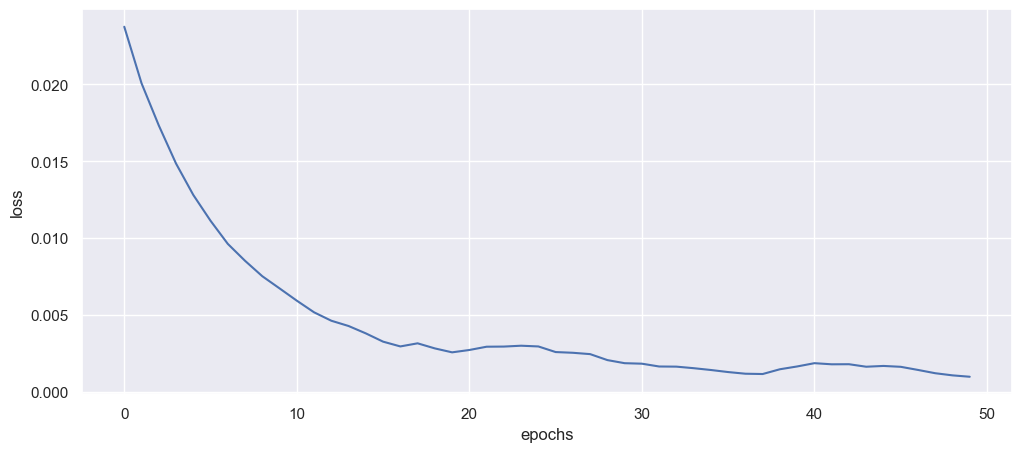

In [53]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

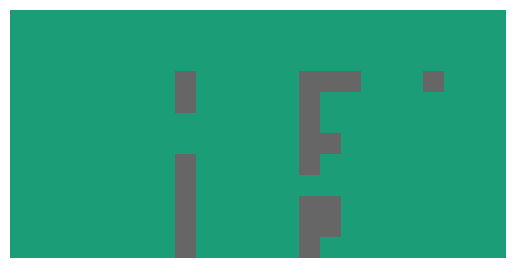

In [54]:
plt.imshow(sdi_1[5], cmap='Dark2')
plt.axis('off')
plt.show()


In [55]:
from tensorflow.keras.losses import MeanSquaredError

mse = MeanSquaredError()

In [56]:
pred_sdi_1 = autoencoder.predict(sdi_1)
pred_sdi_0 = autoencoder.predict(sdi_0)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [57]:
print(f'Reconstruction loss for SDI=1: {mse(sdi_1, pred_sdi_1)}.')
print(f'Reconstruction loss for SDI=0: {mse(sdi_0, pred_sdi_0)}.')

Reconstruction loss for SDI=1: 0.027168190106749535.
Reconstruction loss for SDI=0: 0.0013927387772127986.
